<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">  
# Project 3: Reddit NLP Classification

Project notebook organisation:<br>
[1 - Data Collection & Gathering](./Project_3.1_Data_Collection.ipynb)<br>
[2 - Data Cleaning & EDA](./Project_3.2_Data_Cleaning_and_EDA.ipynb)<br>
**3 - Modelling and Evaluation** (current notebook)<br>

## Part 3: Modelling & Evaluation

In [2]:
# Import libraries
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn2_circles
%matplotlib inline

from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk import WordNetLemmatizer
from nltk.stem import PorterStemmer

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import BaggingClassifier

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, roc_curve, RocCurveDisplay, plot_roc_curve, roc_auc_score, recall_score, precision_score, f1_score

## Import data

In [4]:
df_combined = pd.read_csv('../data/combined_cleaned.csv')

In [ ]:
df_combined.subreddit.value_counts(normalize = True)

In [ ]:
df_combined.head()

## Perform Train, Test, split

In [5]:
#Define X, y of unmodified, lemmatized and stemmed text
X = df_combined['combined_text']
X_lem = df_combined['lem_combined_text']
X_stem = df_combined['stem_combined_text']

y = df_combined['subreddit']

In [6]:
#Perform train test split on Unmodified words
X_train_main, X_test_main, y_train_main, y_test_main = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [7]:
#Perform train test split on Lemmatized words
X_train_lem, X_test_lem, y_train_lem, y_test_lem = train_test_split(X_lem, y, test_size = 0.2, random_state = 42)

In [8]:
#Perform train test split on Stemmed words
X_train_stem, X_test_stem, y_train_stem, y_test_stem = train_test_split(X_stem, y, test_size = 0.2, random_state = 42)

## Establish baseline accuracy for comparison to models ####

In [9]:
y.value_counts(normalize = True)

0    0.503929
1    0.496071
Name: subreddit, dtype: float64

The baseline accuracy is about 50.3% as majority class ('subreddit' == 'r/wallstreetbets') comprise 50.3% of the data. Therefore, if we predict that all posts is from wallstreetbets, we would be correct 50.3% of the time

## Define a function for Pipeline Models run and results ####

In [41]:
common_words = ['stock', 'shares', 'like', 'company', 'one', 'market', 'im', 'time', 'would', 'price']
#Add additional common stop words to the stopwords corpus
stoplist = stopwords.words('english') + common_words

In [42]:
def run_model_rs(pipeline, parameters, cv = 3, model_name = '', kind = ''):
    gs = GridSearchCV(pipeline, parameters, cv = cv, n_jobs = -1, verbose = 1)

    # Fit the Gridsearch to Training data (Unmodified, Lemmatized, Stemmed)
    if kind == 'unmodified':
        X_train = X_train_main
        X_test = X_test_main
        y_train = y_train_main
        y_test = y_test_main

    elif kind == 'lem':
        X_train = X_train_lem
        X_test = X_test_lem
        y_train = y_train_lem
        y_test = y_test_lem

    elif kind == 'stem':
        X_train = X_train_stem
        X_test = X_test_stem
        y_train = y_train_stem
        y_test = y_test_stem

    gs.fit(X_train, y_train)

    # Print the best score found on training data
    print('Best Score:', gs.best_score_)
    # Print the best parameters found on training data
    print('Best Parameters:', gs.best_params_)
    # Use the best estimator that gave the highest score
    gs = gs.best_estimator_
    #Score model on Training data
    print('Score on Training Data:', gs.score(X_train, y_train))
    # Score model on Testing data
    print('Score on Testing Data:', gs.score(X_test, y_test))
    # Get predictions
    y_pred = gs.predict(X_test)

    # Confusion Matrix
    cm = confusion_matrix(y_test,y_pred)
    # Plot Confusion Matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.show()

    # Save performance metrics value
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    # Print the different metrics
    # Append metrics and scores to the dictionary
    accuracy = round(accuracy_score(y_test, y_pred),3) # Accuracy 
    print('Accuracy:', accuracy)
    precision = round(tp / (tp + fp),3) # Precision (Positive Predictive Value)
    print('Precision:', precision)
    recall = round(tp / (tp + fn),3) # Recall (Sensitivity, True Positive Rate)
    print('Recall:', recall)
    specificity = round(tn / (tn + fp),3) # Specificity (True Negative Rate)
    f1 = round(2 * (precision * recall) / (precision + recall),3) #F1
    print('F1:', f1)
    roc_auc = round(roc_auc_score(y_test, y_pred),3) #ROC AUC
    print('ROC AUC:', roc_auc)

    train_score = round(gs.score(X_train, y_train),3)
    test_score = round(gs.score(X_test, y_test),3)
    generalisation = round((train_score - test_score)*100/train_score,3)
    results[model_name] = [train_score, test_score, generalisation, accuracy, precision, recall, specificity, f1, roc_auc]

## Set up Pipelines and Parameters for Gridsearch

In [43]:
# CountVectorizer + Random Forest     
pipe_cvec_rf = Pipeline([ ('cvec', CountVectorizer()),('rf', RandomForestClassifier())])

# TfidfVectorizer + Random Forest (2.5)      
pipe_tfidf_rf = Pipeline([ ('tfidf', TfidfVectorizer()),('rf', RandomForestClassifier())])  

In [44]:
# CountVectorizer + Naive Bayes 
pipe_cvec_mnb = Pipeline([ ('cvec', CountVectorizer()),('mnb', MultinomialNB())])

# TfidfVectorizer + Naive Bayes 
pipe_tfidf_mnb = Pipeline([ ('tfidf', TfidfVectorizer()),('mnb', MultinomialNB())]) 

In [45]:
# CountVectorizer + Gradient Boosting     
pipe_cvec_gboost = Pipeline([ ('cvec', CountVectorizer()),('gboost', GradientBoostingClassifier())])

# TfidfVectorizer + Gradient Boosting      
pipe_tfidf_gboost = Pipeline([ ('tfidf', TfidfVectorizer()),('gboost', GradientBoostingClassifier())]) 

In [46]:

params_cvec_rf = {
    'cvec__max_features': [100,200,300],
    'cvec__min_df': [2,3],
    'cvec__max_df': [.85,.9,.95],
    'cvec__ngram_range': [(1,1), (1,2)],
    'cvec__stop_words': [stoplist],
    'rf__max_depth' : [3,5,7],
    'rf__n_estimators': [100, 150, 200],
    #'rf__class_weight' : ['balanced', {0:1,1:200}]
    #'rf__max_features': [None, 3, 4]
}

params_tfidf_rf = {
    'tfidf__max_features': [100,200,300],
    'tfidf__min_df': [2,3],
    'tfidf__max_df': [.85,.9,.95],
    'tfidf__ngram_range': [(1,1), (1,2)],
    'tfidf__stop_words': [stoplist],
    'rf__max_depth' : [3,5,7],
    'rf__n_estimators': [100, 150, 200],
    #'rf__class_weight' : ['balanced', {0:1,1:200}]
    #'rf__max_features': [None, 3, 4]
}


params_cvec_mnb = {
    'cvec__max_features' : [100, 200, 500],
    'cvec__min_df': [2,3],
    'cvec__max_df': [.85,.9,.95],
    'cvec__stop_words': [stoplist],
    'cvec__ngram_range': [(1,1), (1,2)],
    'mnb__alpha': [1, .9, .8],
}

params_tfidf_mnb = {
    'tfidf__max_features' : [100, 200, 500],
    'tfidf__min_df': [2,3],
    'tfidf__max_df': [.85,.9,.95],
    'tfidf__stop_words': [stoplist],
    'tfidf__ngram_range': [(1,1), (1,2)],
    'mnb__alpha': [1, .9, .8]
}

In [47]:
#Create a dictionary to house the different models score
results = {}

## Random Forest Model
### CountVectorizer ####
#### Unmodified text

Fitting 3 folds for each of 324 candidates, totalling 972 fits
Best Score: 0.6971185330713818
Best Parameters: {'cvec__max_df': 0.95, 'cvec__max_features': 300, 'cvec__min_df': 3, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 

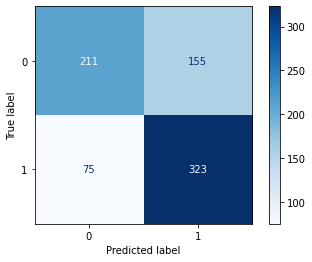

Accuracy: 0.699
Precision: 0.676
Recall: 0.812
F1: 0.738
ROC AUC: 0.694


In [48]:
run_model_rs(pipe_cvec_rf, params_cvec_rf, kind = 'unmodified', model_name = 'Random Forest Count Vectorizer Unmodifed')

##### Lemmatized text

Fitting 3 folds for each of 324 candidates, totalling 972 fits
Best Score: 0.6863130320890635
Best Parameters: {'cvec__max_df': 0.9, 'cvec__max_features': 300, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', '

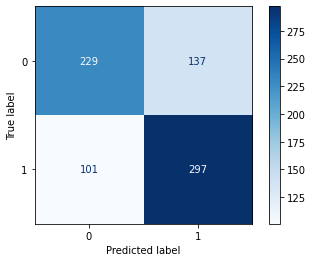

Accuracy: 0.688
Precision: 0.684
Recall: 0.746
F1: 0.714
ROC AUC: 0.686


In [50]:
run_model_rs(pipe_cvec_rf, params_cvec_rf, kind = 'lem', model_name = 'Random Forest Count Vectorizer Lemmatized')

##### Stemmed text

Fitting 3 folds for each of 324 candidates, totalling 972 fits
Best Score: 0.6879502292075966
Best Parameters: {'cvec__max_df': 0.9, 'cvec__max_features': 300, 'cvec__min_df': 3, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', '

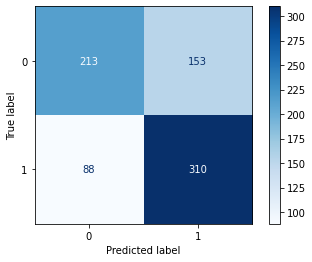

Accuracy: 0.685
Precision: 0.67
Recall: 0.779
F1: 0.72
ROC AUC: 0.68


In [52]:
run_model_rs(pipe_cvec_rf, params_cvec_rf, kind = 'stem', model_name = 'Random Forest Count Vectorizer Stemmed')

### TfidfVectorizer ###
#### Unmodified text

Fitting 3 folds for each of 324 candidates, totalling 972 fits
Best Score: 0.7030124426981009
Best Parameters: {'rf__max_depth': 7, 'rf__n_estimators': 200, 'tfidf__max_df': 0.85, 'tfidf__max_features': 300, 'tfidf__min_df': 3, 'tfidf__ngram_range': (1, 1), 'tfidf__stop_words': ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from'

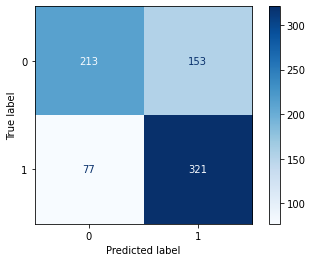

Accuracy: 0.699
Precision: 0.677
Recall: 0.807
F1: 0.736
ROC AUC: 0.694


In [54]:
run_model_rs(pipe_tfidf_rf, params_tfidf_rf, kind = 'unmodified', model_name = 'Random Forest TF-IDF Unmodifed')

##### Lemmatized text

Fitting 3 folds for each of 324 candidates, totalling 972 fits
Best Score: 0.6915520628683693
Best Parameters: {'rf__max_depth': 7, 'rf__n_estimators': 150, 'tfidf__max_df': 0.95, 'tfidf__max_features': 200, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2), 'tfidf__stop_words': ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from'

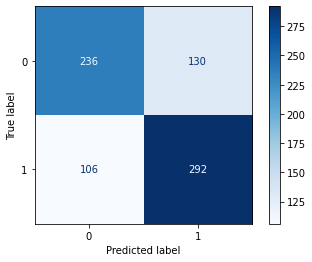

Accuracy: 0.691
Precision: 0.692
Recall: 0.734
F1: 0.712
ROC AUC: 0.689


In [56]:
run_model_rs(pipe_tfidf_rf, params_tfidf_rf, kind = 'lem', model_name = 'Random Forest TF-IDF Lemmatized')

##### Stemmed text

Fitting 3 folds for each of 324 candidates, totalling 972 fits
Best Score: 0.7030124426981009
Best Parameters: {'rf__max_depth': 7, 'rf__n_estimators': 100, 'tfidf__max_df': 0.9, 'tfidf__max_features': 300, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 1), 'tfidf__stop_words': ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from',

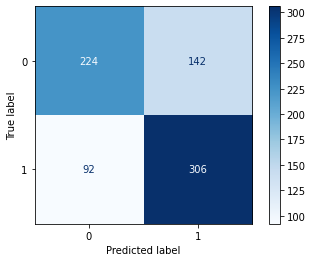

Accuracy: 0.694
Precision: 0.683
Recall: 0.769
F1: 0.723
ROC AUC: 0.69


In [58]:
run_model_rs(pipe_tfidf_rf, params_tfidf_rf, kind = 'stem', model_name = 'Random Forest TF-IDF Stemmed')

## Multinomial Naive Bayes Model ####
### CountVectorizer
#### Unmodified Text

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best Score: 0.6787819253438115
Best Parameters: {'cvec__max_df': 0.85, 'cvec__max_features': 500, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 

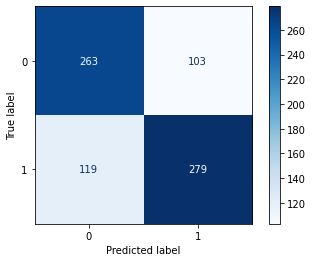

Accuracy: 0.709
Precision: 0.73
Recall: 0.701
F1: 0.715
ROC AUC: 0.71


In [60]:
run_model_rs(pipe_cvec_mnb, params_cvec_mnb, kind = 'unmodified', model_name = 'Naive Bayes CountVectorizer Unmodifed')

#### Lemmatized Text

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best Score: 0.6725605762933857
Best Parameters: {'cvec__max_df': 0.85, 'cvec__max_features': 500, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 

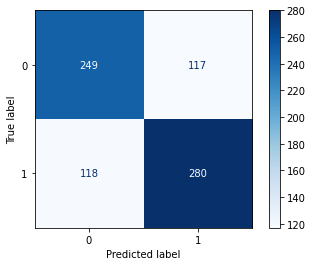

Accuracy: 0.692
Precision: 0.705
Recall: 0.704
F1: 0.704
ROC AUC: 0.692


In [62]:
run_model_rs(pipe_cvec_mnb, params_cvec_mnb, kind = 'lem', model_name = 'Naive Bayes CountVectorizer Lemmatized')

#### Stemmed Text

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best Score: 0.6781270464963981
Best Parameters: {'cvec__max_df': 0.85, 'cvec__max_features': 500, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 

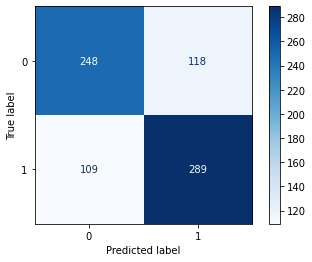

Accuracy: 0.703
Precision: 0.71
Recall: 0.726
F1: 0.718
ROC AUC: 0.702


In [64]:
run_model_rs(pipe_cvec_mnb, params_cvec_mnb, kind = 'stem', model_name = 'Naive Bayes CountVectorizer Stemmed')

### TF-IDF Vectorizer
#### Unmodified Text

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best Score: 0.7085789129011132
Best Parameters: {'mnb__alpha': 1, 'tfidf__max_df': 0.85, 'tfidf__max_features': 500, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2), 'tfidf__stop_words': ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out',

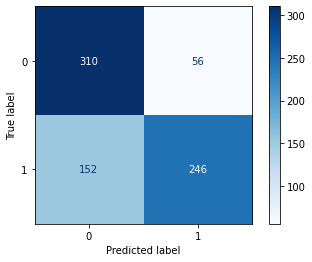

Accuracy: 0.728
Precision: 0.815
Recall: 0.618
F1: 0.703
ROC AUC: 0.733


In [66]:
run_model_rs(pipe_tfidf_mnb, params_tfidf_mnb, kind = 'unmodified', model_name = 'Naive Bayes TF-IDF Unmodifed')

#### Lemmatized Text

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best Score: 0.7010478061558612
Best Parameters: {'mnb__alpha': 0.9, 'tfidf__max_df': 0.85, 'tfidf__max_features': 500, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2), 'tfidf__stop_words': ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out

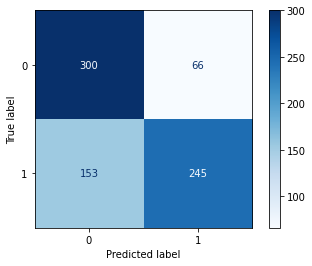

Accuracy: 0.713
Precision: 0.788
Recall: 0.616
F1: 0.691
ROC AUC: 0.718


In [68]:
run_model_rs(pipe_tfidf_mnb, params_tfidf_mnb, kind = 'lem', model_name = 'Naive Bayes TF-IDF Lemmatized')

#### Stemmed Text

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best Score: 0.7174197773411919
Best Parameters: {'mnb__alpha': 1, 'tfidf__max_df': 0.85, 'tfidf__max_features': 500, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 1), 'tfidf__stop_words': ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out',

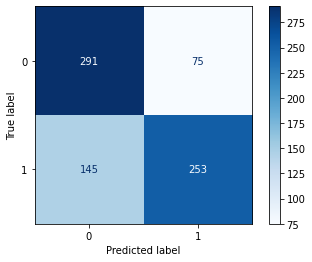

Accuracy: 0.712
Precision: 0.771
Recall: 0.636
F1: 0.697
ROC AUC: 0.715


In [70]:
run_model_rs(pipe_tfidf_mnb, params_tfidf_mnb, kind = 'stem', model_name = 'Naive Bayes TF-IDF Stemmed')

## Model evaluation and recommendations

In [71]:
results_df = pd.DataFrame(results, index=['Train score', 'Test score', 'Generalisation','Accuracy', 'Precision', 'Recall', 'Specificity','F1', 'ROC AUC']).T
                            
results_df

,Train score,Test score,Generalisation,Accuracy,Precision,Recall,Specificity,F1,ROC AUC
Random Forest Count Vectorizer Unmodifed,0.725,0.699,3.586,0.699,0.676,0.812,0.577,0.738,0.694
Random Forest Count Vectorizer Lemmatized,0.711,0.688,3.235,0.688,0.684,0.746,0.626,0.714,0.686
Random Forest Count Vectorizer Stemmed,0.724,0.685,5.387,0.685,0.670,0.779,0.582,0.720,0.680
Random Forest TF-IDF Unmodifed,0.744,0.699,6.048,0.699,0.677,0.807,0.582,0.736,0.694
Random Forest TF-IDF Lemmatized,0.727,0.691,4.952,0.691,0.692,0.734,0.645,0.712,0.689
Random Forest TF-IDF Stemmed,0.762,0.694,8.924,0.694,0.683,0.769,0.612,0.723,0.690
Naive Bayes CountVectorizer Unmodifed,0.702,0.709,-0.997,0.709,0.730,0.701,0.719,0.715,0.710
Naive Bayes CountVectorizer Lemmatized,0.693,0.692,0.144,0.692,0.705,0.704,0.680,0.704,0.692
Naive Bayes CountVectorizer Stemmed,0.702,0.703,-0.142,0.703,0.710,0.726,0.678,0.718,0.702
Naive Bayes TF-IDF Unmodifed,0.751,0.728,3.063,0.728,0.815,0.618,0.847,0.703,0.733


In [72]:
#Best model
best_model = GridSearchCV(pipe_tfidf_mnb, params_tfidf_mnb, cv = 5, n_jobs = -1, verbose = 1)
best_model = best_model.fit(X_train_main, y_train_main)
best_model.best_params_
y_pred = best_model.predict(X_test_main)
y_proba = best_model.predict_proba(X_test_main)[:,1]
auc = round(roc_auc_score(y_test_main, y_proba),3)


Fitting 5 folds for each of 108 candidates, totalling 540 fits


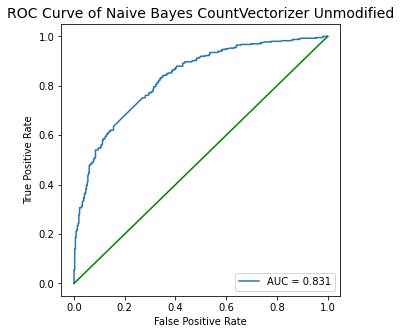

In [73]:
# Define a function to plot the ROC curve of the best model
def plot_sklearn_roc_curve(y_real, y_pred):
    fpr, tpr, thresholds = roc_curve(y_real, y_pred)
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, estimator_name = f'AUC = {auc}').plot()
    roc_display.figure_.set_size_inches(5,5)
    plt.plot([0, 1], [0, 1], color = 'g')
    plt.title('ROC Curve of Naive Bayes CountVectorizer Unmodified', fontsize = 14)
    plt.legend(loc = 'lower right')

plot_sklearn_roc_curve(y_test_main, y_proba)

In total, the 3 different type of text data (Unmodified, Lemmatized and Stemmed) were inserted into the model of 2 different classifiers (RandomForest and Naive Bayes) utilising both CountVectorizer and TfidVectorizer to obtain 12 differen sets of results for evaluation.

By employing text preprocessing such as stemming and lemmatization, we reduce the words to a common word root. This allows the words to be treated similarly and the model learns that they can be used in similar contexts. 

To evaluate the models, we will be using accuracy and precision as our main evaluation metrics. For precision and recall, there is a trade off between them. By increasing precision, we will decrease the recall. For a Subreddit classification model, we will want to maximise precision as we want to be correct when the subreddit are classified correctly. As there is minimal data imbalance, F1 score will not be a determining metric for evaluation. 

Specificity and sensitive will also not be used as it is not important to measure the proportion of positive class that is correctly predicted as positive as the impact of a wrong prediction is not fatal. 

ROC AUC score is also used as a consideration for evaluation with the score ranging from 0.5 to 1, where 1 is a perfect score which the model can predict classes correctly everytime and 0.5 means the model is as good as random. As our model have a score of 0.831, it shows a very good performance.

From the table above, the Naive Bayes model with the TF-IDF preprocessing on unmodified text will be the most suitable model to be used for our dataset.






Let us explore more on our selected model on how it perform with wrongly classified post and the feature importances of the model.
## Wrongly classified post

In [74]:
text_pred = list(zip(X_test_main, y_test_main, y_pred,))
text_pred_df = pd.DataFrame(text_pred, columns = ['Text', 'Actual', 'Predicted'])

In [75]:
pd.set_option("display.max_colwidth", 4500)
pd.set_option("display.max_rows", 1000)

# Find those texts with wrong predictions (0 for stcoks, 1 for wsb)
# Display only first 10, to see all, please delete .head(10)

text_pred_df[text_pred_df['Actual']!=text_pred_df['Predicted']].head(10)

Text  \
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

There is still room for improvement for the model as there are posts that are not classified correctly.

## Model features

In [76]:
log_prob_pos = gs_clf.best_estimator_['mnb'].feature_log_prob_[1]
log_prob_neg = gs_clf.best_estimator_['mnb'].feature_log_prob_[0]
log_prob_difference = log_prob_pos - log_prob_neg

features_names = gs_clf.best_estimator_.named_steps['tfidf'].get_feature_names_out()

prob_word_list = sorted(zip(features_names, log_prob_difference), 
                      key = lambda x: abs(x[1]), reverse = True)

prob_word_list_df = pd.DataFrame(columns = ['Word', 'Log Probability Difference'], data = prob_word_list).head(50)

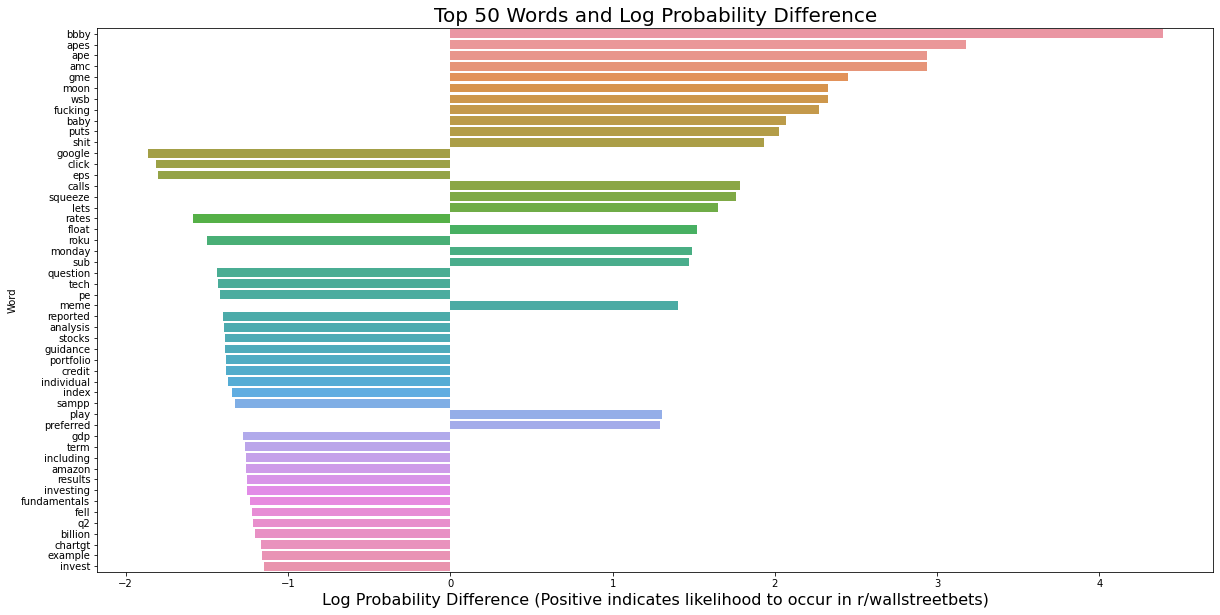

In [77]:
plt.figure(figsize = (20,10))
sns.barplot(
    y = 'Word',
    x = 'Log Probability Difference',
    data = prob_word_list_df
)
plt.title('Top 50 Words and Log Probability Difference', fontsize = 20)
plt.xlabel('Log Probability Difference (Positive indicates likelihood to occur in r/wallstreetbets)', fontsize = 16)
plt.savefig("top50words.png", transparent = True)

Among the top 50 words, we can see that words with positve probability difference mainly belongs to r/wallstreetbets and vice versa for r/stocks. 
For r/wallstreetbets, the features centres around meme stock tickers (bbby, amc, gme) or options trading (calls, puts, squeeze)
Conversely, for r/stocks, the features are related to long term investing (index, investing, s&p) and company fundamentals (eps, guidance, pe)


## Recommendation & Conclusion

In [ ]:
#Display the selected model
results_df.iloc[7,[0,1,2,4,7,8]]

The Naïve Bayes Model with TF-IDF Vectorizer on Unmodified text will be the final model selected for the subreddit classifier as it is the best performing model with its accuracy, precision and AUC score.

The following can be explored to further improve the model accuracy and to find the best parameters.
- More hyperparameter tuning and classifiers can be explored to further increase the accuracy of the classifier
- More weightage can be assigned to Title than self text
- As there are high frequency postings in both r/wallstreetbets and r/stocks, we can consider to scrape only popular posts in order to improve the quality of the scrapped data and reduce spam
- Explore sentimental analysis to the model to determine the positive and negative sentiments of the posts
- Develop a list of popular tickers and stop words to add to the stopwords corpus
